<a href="https://colab.research.google.com/github/Mohamed01555/Adult-income/blob/master/face_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [54]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'

In [ ]:
!kaggle  datasets download --force -d abhikjha/utk-face-cropped

In [ ]:
!unzip \*.zip  && rm *.zip

In [143]:
import os
os.chdir('/content/utkcropped')

temp = os.listdir()
import fnmatch
dataset = fnmatch.filter(temp, '*_*_*_*')
m = len(dataset)
print(m)

23705


In [144]:
from random import shuffle
shuffle(dataset)

In [188]:
import numpy as np
from matplotlib.pyplot import imread
import cv2
X_data =[]
for file in dataset:
    face = mpimg.imread(file)
    face = cv2.resize(face, (128, 128))
    X_data.append(face)
X = np.squeeze(X_data)

In [189]:
X = X.astype('float32')
X /= 255.0

In [190]:
X.shape

(23705, 128, 128, 3)

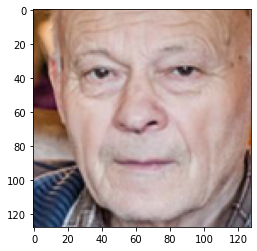

In [193]:
import matplotlib.pyplot
matplotlib.pyplot.imshow(X[870], )#image = Image.open(X[5])

In [313]:
import tensorflow
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

input_img = Input(shape=(128, 128, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='valid')(x)
x = Dropout(0.5)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='valid')(x)
x = Dropout(0.5)(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='valid')(x)
x = Dropout(0.5)(x)

x = Flatten()(encoded)
x = Dropout(0.5)(x)

embedding = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(4096, activation='relu')(embedding)
x = Dropout(0.5)(x)
x = tensorflow.reshape(x, (-1,16,16,16))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.5)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer=tensorflow.keras.optimizers.Adam() , loss=losses.mean_squared_error , metrics=['mae'])

autoencoder.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_168 (Dropout)        (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 64, 64, 32)        924

In [209]:
autoencoder.fit(X,X,
                epochs=30,
                batch_size=128,
                shuffle=True)

Epoch 1/30
186/186 [==============================] - 49s 261ms/step - loss: 0.0356 - mae: 0.1461
Epoch 2/30
186/186 [==============================] - 49s 261ms/step - loss: 0.0204 - mae: 0.1082
Epoch 3/30
186/186 [==============================] - 49s 261ms/step - loss: 0.0181 - mae: 0.1011
Epoch 4/30
186/186 [==============================] - 49s 261ms/step - loss: 0.0169 - mae: 0.0974
Epoch 5/30
186/186 [==============================] - 48s 260ms/step - loss: 0.0161 - mae: 0.0950
Epoch 6/30
186/186 [==============================] - 49s 261ms/step - loss: 0.0156 - mae: 0.0933
Epoch 7/30
186/186 [==============================] - 48s 260ms/step - loss: 0.0151 - mae: 0.0917
Epoch 8/30
 63/186 [=========>....................] - ETA: 31s - loss: 0.0149 - mae: 0.0909

KeyboardInterrupt: ignored

In [230]:
%cd '/content/gdrive/My Drive/Kaggle'

/content/gdrive/My Drive/Kaggle


In [231]:
autoencoder.save('complete_autoencoder.hf')

INFO:tensorflow:Assets written to: complete_autoencoder.hf/assets


In [316]:
encoder = Model(autoencoder.layers[0].input, embedding)

In [318]:
encoder.save('encoder.h5')

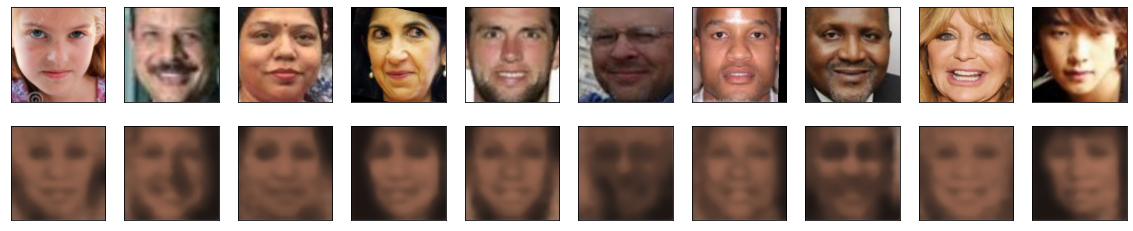

In [214]:
import matplotlib.pyplot as plt


decoded_imgs = autoencoder.predict(X[:100])

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X[i+51].reshape(128, 128,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i+51].reshape(128, 128,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [173]:
import matplotlib.image as mpimg

In [215]:
face = mpimg.imread('/content/2020-07-13-002219.jpg')
v = cv2.resize(face, (128, 128))
v = v.astype('float32') / 255.0
v = v.reshape((1,128,128,3))
my_decoded_image = autoencoder.predict(v)

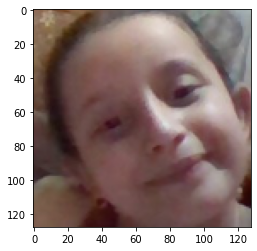

In [216]:
face = mpimg.imread('/content/2020-07-13-002219.jpg')
v = cv2.resize(face, (128, 128))
v = v.astype('float32') / 255.0
plt.imshow(v)

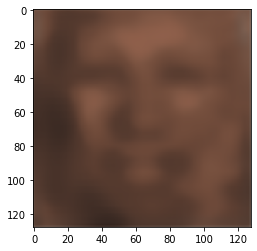

In [217]:
plt.imshow(my_decoded_image.reshape((128,128,3)))

In [314]:
%cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
encoder.load_weights('face_encoder.h5')

In [309]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

def preprocess_image(my_image):
  my_face = mpimg.imread(my_image)
  #plt.imshow(my_face,cmap='gray')
  my_face = cv2.resize(my_face,(128,128))
  my_face = my_face.astype('float32') / 255.0 
  my_face = my_face.reshape((1,128,128,3))
  encoded_face = encoder(my_face)
  #reshape it to a vector
  encoded_face_vector = tf.reshape(encoded_face,((16*16),1)).numpy()

  return encoded_face_vector

In [310]:
l = []
l.append(preprocess_image('/content/2020-07-12-182545.jpg'))

In [249]:
from scipy import spatial

In [312]:
def compare(image):
  image = preprocess_image(image)

  for img in l:
    result = 1 - spatial.distance.cosine(img, image)
    print(result)
    if result <= 0.9:
      print('This is not my image')
    # else:
    #   print('verified!!')
    #   l.append(image)

In [311]:
compare('/content/2020-07-13-103804.jpg')

0.717641294002533


In [267]:
compare('/content/IMG_20200713_132126.jpg')

0.8434047102928162


In [268]:
compare('/content/2020-07-12-235147.jpg')

0.86653071641922


In [269]:
compare('/content/2020-07-13-002219.jpg')

0.8675285577774048


# Nother trial to use the max-pooling layer as ecoder instead of using 256 dense layer

In [279]:
encoder = Model(autoencoder.layers[0].input, encoded)

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

def preprocess_image(my_image):
  my_face = mpimg.imread(my_image)
  #plt.imshow(my_face,cmap='gray')
  my_face = cv2.resize(my_face,(128,128))
  my_face = my_face.astype('float32') / 255.0 
  my_face = my_face.reshape((1,128,128,3))
  encoded_face = encoder(my_face)
  #reshape it to a vector
  encoded_face_vector = tf.reshape(encoded_face,((16*16*16),1)).numpy()

  return encoded_face_vector

In [293]:
def compare(image):
  image = preprocess_image(image)

  for img in l:
    result = 1 - spatial.distance.cosine(img, image)
    print(result)
    if result <= 0.65:
      print('This is not my image')
    # else:
    #   print('verified!!')
    #   l.append(image)

In [284]:
preprocess_image('/content/2020-07-13-103804.jpg').shape

(4096, 1)

In [302]:
l = []
l.append(preprocess_image('/content/2020-07-12-182545.jpg'))

In [303]:
compare('/content/2020-07-13-103804.jpg')

0.5020911693572998
This is not my image


In [304]:
compare('/content/IMG_20200713_132126.jpg')

0.6222056150436401
This is not my image


In [305]:
compare('/content/2020-07-12-203517.jpg')

0.6615480184555054


In [306]:
compare('/content/2020-07-12-235147.jpg')

0.7780135869979858


In [307]:
compare('/content/2020-07-13-162740.jpg')

0.7696642875671387
